In [8]:
import pyemma as pm
import mdtraj as md
from molpx.generate import projection_paths
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from typing import Dict, Union, List
from msmsense.featurizers import dihedrals, distances
from msmsense.bootstrap_cmatrices import get_sub_dict, get_trajs
from functools import partial
import functions as funcs

%matplotlib inline

import pickle
import time
import seaborn as sns

# Globals and functions

In [9]:
def get_feature_dict(df, row_num):
    row_dict = df.filter(regex='__', axis=1).iloc[row_num, :].to_dict()
    feature_dict = get_sub_dict(row_dict, 'feature')
    if feature_dict['value'] == 'distances':
        feature_dict.update(get_sub_dict(row_dict, 'distances'))
    if feature_dict['value'] == 'dihedrals':
        feature_dict.update(get_sub_dict(row_dict, 'dihedrals'))
    return feature_dict

def get_kws_dict(df, row_num, kws):
    row_dict = df.filter(regex='__', axis=1).iloc[row_num, :].to_dict()   
    kws_dict = get_sub_dict(row_dict, kws)
    return kws_dict

def set_proper_dtypes(df):
    """
    forgot to save integers as integers. Only the distances feature columns have true floats. 
    """
    float_cols = list(df.filter(regex='distances.*', axis=1)) + list(df.filter(regex='.*vamp.*', axis=1)) 
    float_cols = float_cols + list(df.filter(regex='.*gap.*', axis=1)) 
    potential_integer_cols = df.columns.difference(float_cols)
    for col in potential_integer_cols:
        if str(df[col].dtype) != 'object':
            df[col] = df[col].astype(int)
    return df

def get_trajs_top(traj_dir: Path, protein_dir: str, rng: Union[np.random.Generator, None]=None):
    trajs = list(traj_dir.rglob(f"*{protein_dir.upper()}*/*.xtc"))
    trajs.sort()
    if rng is not None:
        ix = rng.choice(np.arange(len(trajs)), size=len(trajs), replace=True)
        trajs = [trajs[i] for i in ix]
    
    top = list(traj_dir.rglob(f"*{protein_dir.upper()}*/*.pdb"))[0]
    
    return {'trajs': trajs, 'top': top}
    
    
def get_random_traj(trajs: List[md.Trajectory], num_frames: int, rng: np.random.Generator)-> md.Trajectory: 
    traj_ix = np.arange(len(trajs))
    frame_ix = [np.arange(traj.n_frames) for traj in trajs]
    
    rand_ix = [(ix, rng.choice(frame_ix[ix])) for ix in rng.choice(traj_ix, size=num_frames)]
    rand_traj = md.join([trajs[x[0]][x[1]] for x in rand_ix])
    return rand_traj
    

In [10]:
class MSM(object):
    
    def __init__(self, lag: int, num_evs: int, trajs: List[md.Trajectory], top: md.Trajectory,
                 feature_kws: Dict[str, Union[str, int, float]], tica_kws: Dict[str, Union[str, int, float]], cluster_kws: Dict[str, Union[str, int, float]], seed: int):
        """
        Defines the whole MSM pipeline.
        lag: markov lag time 
        num_evs: number of eigenvectors in VAMP score. This includes stationary distribution. note: all projections are done onto the processes 1 - num_evs, i.e., exclude the stationary distribution (process 0)
        traj_top_paths: dictionary with 'trajs' - list of Paths to trajectories, and 'top' Path to topology file. 
        
        """
        self.lag = lag
        self.num_evs = num_evs
        self.trajs = trajs

        self.top = top
        self.feature_kws = feature_kws
        self.tica_kws = tica_kws
        self.cluster_kws = cluster_kws
        self.featurizer = None
        self._set_featurizer()
        self.seed = seed

        self.ttrajs = None
        self.tica = None
        self.cluster = None
        self.msm = None
        self.paths = None
        
    def _set_featurizer(self):
        feature_kws = self.feature_kws.copy()
        feature = feature_kws.pop('value')
        
        if feature == 'distances':
            self.featurizer = partial(distances, **feature_kws)
        elif feature == 'dihedrals':
            self.featurizer = partial(dihedrals, **feature_kws)
        else:
            raise NotImplementedError('Unrecognized feature')
        

    def fit(self):
        ftrajs = self.featurizer(self.trajs)
        self.tica = pm.coordinates.tica(data=ftrajs, **self.tica_kws)
        ttrajs = self.tica.get_output()
        self.ttrajs = ttrajs
        self.cluster = pm.coordinates.cluster_kmeans(data=ttrajs, **self.cluster_kws, fixed_seed=self.seed)
        dtrajs = self.cluster.dtrajs
        self.msm = pm.msm.estimate_markov_model(dtrajs=dtrajs, lag=self.lag)

    
    def _get_all_projections(self, num_procs: int, dtrajs: List[np.ndarray]) -> np.ndarray:
        """ Project dtrajs onto first num_proc eigenvectors excluding stationary distribution. i.e., if num_proc=1 then project onto the slowest eigenvector only. 
        All projections ignore the stationary distribution
        """
        evs = self.msm.eigenvectors_right(num_procs+1)
        active_set = self.msm.active_set
        NON_ACTIVE_PROJ_VAL = 0 # if the state is not in the active set, set the projection to this value. 
        NON_ACTIVE_IX_VAL = -1
        evs = evs[:, 1:] # remove the stationary distribution
        proj_trajs = []
        for dtraj in dtrajs:
            all_procs = []
            for proc_num in range(num_procs):
                
                tmp = np.ones(dtraj.shape[0], dtype=float)
                tmp[:] = NON_ACTIVE_PROJ_VAL
                
                for i in range(dtraj.shape[0]):
                    x = self.msm._full2active[dtraj[i]]
                    if x != NON_ACTIVE_IX_VAL:
                        tmp[i] = evs[x, proc_num]
                    tmp = tmp.reshape(-1, 1)
                
                all_procs.append(tmp)
            all_procs = np.concatenate(all_procs, axis=1)
            proj_trajs.append(all_procs)
        
        return proj_trajs
        
        
    def projection_paths(self, n_projs: Union[None, int]=None, proj_dim: Union[None, int]=None, n_points: int=100, n_geom_samples: int=100):
        """
        n_projs: number of paths to create. Default = None = num_evs - 1 (i.e., exclude stationary distribution)
        proj_dim: dimensionality of the space in which distances will be computed. Default = None = num_evs - 1 (i.e., exclude stationary distribution)
        n_points: number of points along the path (there may be less than this.)
        n_geom_samples: For each of the n_points along the projection path, n_geom_samples will be retrieved from the trajectory files. 
                        The higher this number, the smoother the minRMSD projection path. Also, the longer it takes for the path to be computed
        """
        
        if proj_dim is None:
            proj_dim = self.num_evs - 1
        if n_projs is None:
            n_projs = self.num_evs - 1
        
        projections = self._get_all_projections(num_procs=proj_dim, dtrajs=self.msm.discrete_trajectories_active)
        
        paths, _ = projection_paths(MD_trajectories=self.trajs, MD_top = self.top, projected_trajectories=projections, 
                                    n_projs=n_projs, proj_dim=proj_dim, n_geom_samples=n_geom_samples, n_points=n_points)
        self.paths = paths
        
        
    
    def get_projection_trajectory(self, proc_num: int, kind: str='min_rmsd') -> md.Trajectory:
        """
        Returns the projection trajectory for a specific dimension
        proc_num: the number process. Min value = 1
        """
        if proc_num == 0:
            raise ValueError("process_num must be >=1. Processes are indexed from 0 (stationary distribution). Process 1 is the slowest projected process.")
            
        return self.paths[proc_num-1][kind]['geom']
    
    
    def transform(self, new_trajectory: md.Trajectory) -> np.ndarray:
        """
        projects new trajectory onto the self.num_proc eigenvectors of the MSM
        """
        ftrajs = self.featurizer([new_trajectory])
        ttrajs = self.tica.transform(ftrajs)
        dtrajs = self.cluster.transform(ttrajs)
        projections = self._get_all_projections(num_procs=self.num_evs - 1, dtrajs=dtrajs)
        return projections
        
        

In [11]:
traj_dir = Path('/Volumes/REA/MD/12FF/strided/')
m1_sel = set_proper_dtypes(pd.read_hdf('./summaries/m1_model_selection.h5'))
m2_sel = set_proper_dtypes(pd.read_hdf('./summaries/m2_model_selection.h5'))

In [12]:
prot_dict = dict(zip(funcs.PROTEIN_LABELS, funcs.PROTEIN_DIRS))

In [13]:
prot_pdbs = {'Chignolin': '5awl.pdb', 'BBA': '1fme.pdb', 'Trp-cage': '2jof.pdb',  'Villin': '2f4k.pdb', 'WW-domain': '2f21.pdb' , 'BBL': '2wxc.pdb' , 'Homeodomain': '2p6j.pdb', 'Protein-B': '1prb.pdb'}

# Detailed comparisons

This workbook fits the best hyperparameters for each feature and provides a more detailed comparison. This complements the model comparison in terms of eigenvector projections. 


In [16]:
seed = 12098345
num_structures = 100 # how many samples

for protein in ['Villin']: #funcs.PROTEIN_LABELS[:4]+funcs.PROTEIN_LABELS[6:9]:

    # Setup output dir
    protein_dir = prot_dict[protein]
#     Path(f"compare_structures/{protein}").mkdir(exist_ok=True)

    # Get trajectories
    traj_paths = get_trajs_top(traj_dir, protein_dir)
    traj_paths_str = dict(top=str(traj_paths['top']), trajs=[str(x) for x in traj_paths['trajs']])
    top = md.load(str(traj_paths['top']))
    trajs = [md.load(str(x), top=top) for x in traj_paths['trajs']]

    # Fit models on a single bootstrap sample

    def fit_model(mod_defs, row_num, trajs, top, seed):

        lag = int(mod_defs.chosen_lag.values[row_num])
        num_evs = int(mod_defs.new_num_its.values[row_num])
        feat_kws = get_feature_dict(mod_defs, row_num)
        tica_kws = get_kws_dict(mod_defs, row_num, 'tica')
        cluster_kws = get_kws_dict(mod_defs, row_num, 'cluster')

        # Fit model
        model = MSM(lag = lag, num_evs=num_evs, trajs=trajs, top=top,  feature_kws=feat_kws, tica_kws=tica_kws, cluster_kws=cluster_kws, seed=seed)
        model.fit()
        return model


    features = m1_sel.feature.unique()
    m1_models = {}
    m2_models = {}

    for feat in features:
        mod_defs = m1_sel.loc[m1_sel.protein==protein, :].copy()
#         mod_defs['tica__stride'] = 2
        row_num = np.where(mod_defs['feature'].values==feat)[0][0]
        m1_models[feat] = fit_model(mod_defs, row_num, trajs, top, seed)

        mod_defs = m2_sel.loc[m2_sel.protein==protein, :].copy()
#         mod_defs['tica__stride'] = 2

        row_num = np.where(mod_defs['feature'].values==feat)[0][0]
        m2_models[feat] = fit_model(mod_defs, row_num, trajs, top, seed)

    # Coarsegrain and extract structures

#     top.save_pdb(f'compare_structures/{protein}/top.pdb') # For easy reference

    all_dfs = []
    all_models = {'VAMP' : m1_models, 'VAMP_and_Gap': m2_models}
    
    for sele_method, models in all_models.items():

        for feat, model in models.items():
            # Do PCCA
            num_procs = model.num_evs
            pcca = model.msm.pcca(m=num_procs)
            sd = pcca.coarse_grained_stationary_probability

            # Sort states and get distributions
            state_ix = np.argsort(sd)[::-1]
            sd = sd[state_ix]
            ms_dist = model.msm.metastable_distributions
            ms_dist = ms_dist[state_ix, :]
            
#             # Get samples
#             samples = [pm.coordinates.save_traj(traj_paths_str['trajs'], idist, outfile=None, top=traj_paths_str['top'])
#                       for idist in model.msm.sample_by_distributions(ms_dist, num_structures)]

#             # Load xtal structure (and save in convenient place)
#             reference = md.load(f"compare_structures/{prot_pdbs[protein]}")
# #             reference.save_pdb(f"compare_structures/{protein}/xtal.pdb")

#             ref_ix = reference.top.select('name CA')
#             for i, traj in enumerate(samples):

#                 # superpose and save structures
#                 ix = traj.top.select('name CA')
#                 traj.superpose(reference=reference, atom_indices=ix, ref_atom_indices=ref_ix)
# #                 traj.save_xtc(f"compare_structures/{protein}/{sele_method}_model_{feat}_state_{i}.xtc")
#                 traj.save_xtc(f"compare_structures/{protein}/tica_2ns_stride/{sele_method}_model_{feat}_state_{i}.xtc")

#                 rmsd = md.rmsd(traj, reference, frame=0,  atom_indices=ix, ref_atom_indices=ref_ix)*10

#                 df = pd.DataFrame(rmsd, columns=['RMSD'])
#                 df['Method'] = sele_method
#                 df['Feature'] = feat
#                 df['State'] = str(i+1)
#                 df['stat_dist'] = sd[i]
#                 all_dfs.append(df)

#     df = pd.concat(all_dfs)
# #     df.to_hdf(f'compare_structures/{protein}/rmsd_all_models.hdf', key='rmsd')
#     df.to_hdf(f'compare_structures/{protein}/tica_2ns_stride/rmsd_all_models.hdf', key='rmsd')


#     with sns.plotting_context('paper', font_scale=1.25):
#         sns.displot(data=df, row='State', col='Feature', x='RMSD', hue='Method', kind='kde')
#         plt.savefig(f"compare_structures/{protein}/tica_2ns_stride/comparison.pdf", bbox_inches='tight')
# #         plt.savefig(funcs.FIG_DIR.joinpath('model_comparisons', f'{protein}_folded_comparison.pdf'), bbox_inches='tight')
#         plt.close()

calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

getting output of KmeansClustering:   0%|                                                                     …

calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

getting output of KmeansClustering:   0%|                                                                     …

calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

getting output of KmeansClustering:   0%|                                                                     …

calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

getting output of KmeansClustering:   0%|                                                                     …

calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

getting output of KmeansClustering:   0%|                                                                     …

calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

getting output of KmeansClustering:   0%|                                                                     …

In [36]:
from scipy.stats import entropy


dists = m1_models['dist.'].msm.metastable_memberships

In [49]:
fake_dists = np.ones((100, 3))/3
np.mean(entropy(fake_dists.T))/((-np.log(1/3)))

0.9999999999999994

In [46]:
np.mean(entropy(dists.T))/(-np.log(1/3))

0.35219167242226174

In [45]:
-np.log(1/3)

1.0986122886681098

In [50]:
hmm = m1_models['dist.'].msm.coarse_grain(3)

In [54]:
np.mean(entropy(hmm.metastable_memberships.T))

0.05919806679241879

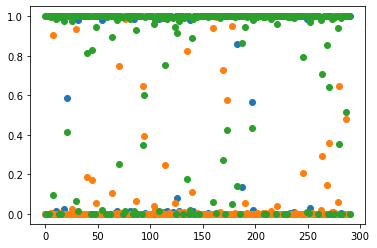

In [58]:
plt.plot(hmm.metastable_memberships, lw=0, marker='o')

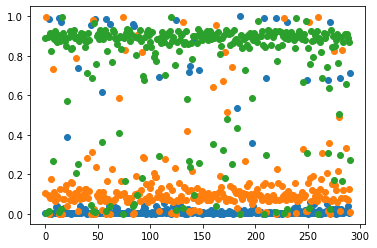

In [60]:
plt.plot(m1_models['dist.'].msm.metastable_memberships, lw=0, marker='o')

In [64]:
np.round(hmm.transition_matrix*100, 1)

array([[97.6,  0. ,  2.4],
       [ 0. , 95.3,  4.7],
       [ 0.2,  1.5, 98.3]])